In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [2]:
params = {'legend.fontsize':'x-large',
         'figure.figsize': (15,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
sns.set_theme(style='darkgrid')
np.random.seed(42)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
le = LabelEncoder()

Load Data

In [5]:
train_data = pd.read_csv('data_set_ALL_AML_train.csv')
test_data = pd.read_csv('data_set_ALL_AML_independent.csv')
labels = pd.read_csv('actual.csv', index_col='patient')

In [6]:
train_data.shape, test_data.shape

((7129, 78), (7129, 70))

The data consists of 7129 rows and 78 columns for training set, and 70 columns for testing set. Each row corresponds to one of the 7129 genes, and each column represents a single patient. Therefore, each cell contains the expression level of a specific gene to a particular patient.

### EDA and Data Preprocessing
- We will assume that the 'call' columns, which seem to be designated for each patient, are unimportant as they do not vary significantly in values and any related information cannot be found in the paper.
- We will also check for null values

In [7]:
print(train_data.isna().sum().sum())
print(test_data.isna().sum().sum())

0
0


In [8]:
cols_train = [col for col in train_data.columns if 'call' in col]
cols_test = [col for col in test_data.columns if 'call' in col]

train_data.drop(cols_train, axis = 1, inplace = True)
test_data.drop(cols_test, axis = 1, inplace = True)

Now we will transpose the columns and rows so that 7129 genes become features, and each patient instance occupies a single row

In [9]:
# Transpose row and columns in training set
train_data = train_data.T

#Transpose row and columns in testing set
test_data = test_data.T

Let's first designate the second row containing the gene accession numbers as the column names. Then, remove both the first two rows of Gene Description and Gene Accession Number

In [10]:
# Set the second row (Gene Accession Number) as the column names
train_data.columns = train_data.iloc[1] # for training set
test_data.columns = test_data.iloc[1] # for testing set

# Drop the first two rows (Gene Description and Gene Accession Number) and reindex

train_data = train_data.iloc[2:].reset_index(drop=True) # for training set
test_data = test_data.iloc[2:].reset_index(drop=True)

print(train_data.shape)
print(test_data.shape)

(38, 7129)
(34, 7129)


In [11]:
# Adding new column
train_data['patient'] = train_data.index.values
test_data['patient'] = test_data.index.values

As most libraries work with numerical data, let's convert data values to numeric

In [12]:
# Convert data values to numeric for training set
train_data = train_data.apply(pd.to_numeric, errors = 'coerce')

#Convert data values to numeric for testing set
test_data = test_data.apply(pd.to_numeric, errors = 'coerce')

In [13]:
labels['cancer'] = le.fit_transform(labels['cancer'])
train_data = pd.merge(train_data, labels, on='patient')
test_data = pd.merge(test_data, labels, on='patient')

In [14]:
train_data['cancer'].value_counts()

0    27
1    10
Name: cancer, dtype: int64

In [15]:
test_data['cancer'].value_counts()

0    27
1     6
Name: cancer, dtype: int64

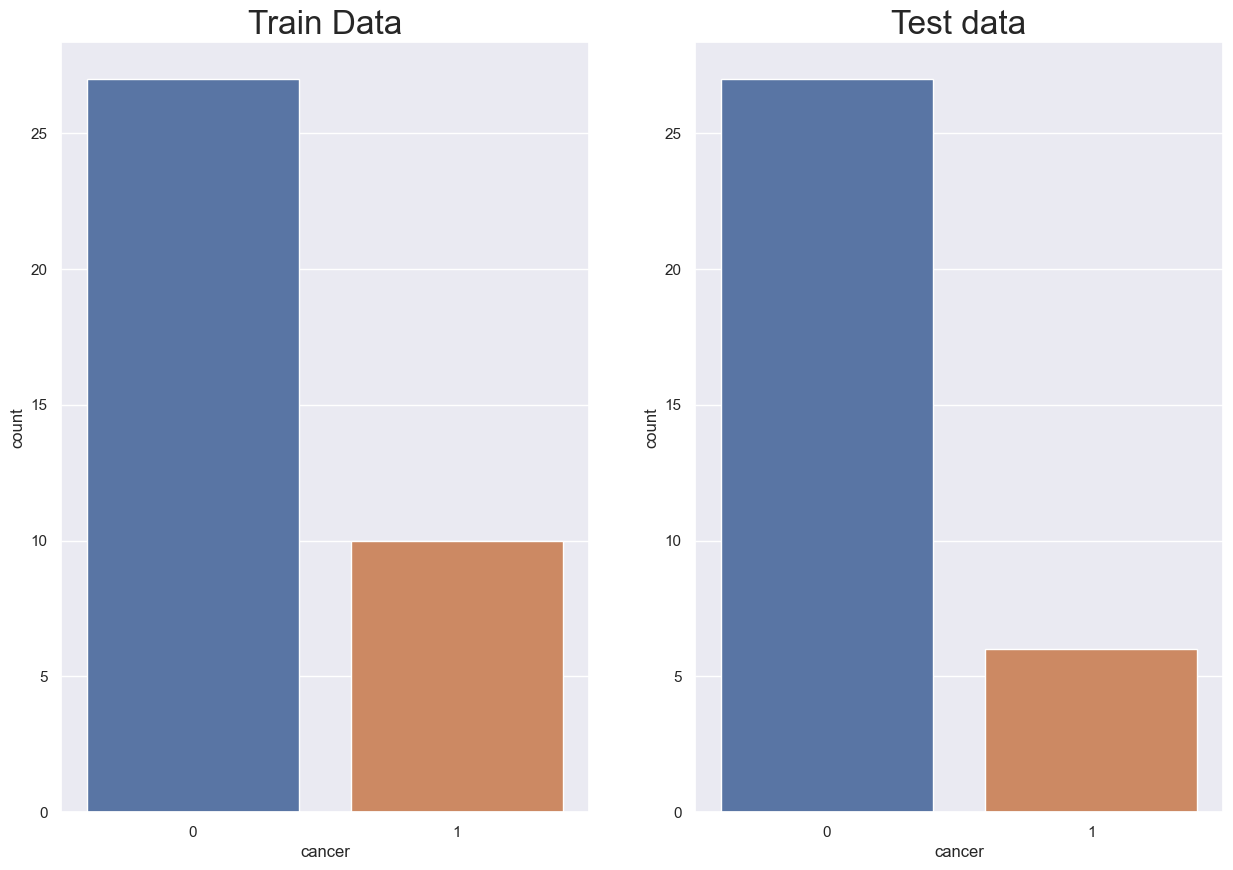

In [16]:
fig, axs = plt.subplots(1,2)
sns.countplot(x = 'cancer', data=train_data, ax=axs[0])
axs[0].set_title('Train Data', fontsize=24)
sns.countplot(x='cancer', data=test_data, ax=axs[1])
axs[1].set_title('Test data', fontsize=24)
plt.show()

Let's use upsampling to combat class imbalance. We can add about 8 additional random samples of **AML** class.

In [17]:
upsampled_data = random.sample(train_data.query('cancer == 1')['patient'].index.to_list(), k=8)

In [18]:
upsampled_data

[30, 36, 35, 32, 27, 33, 34, 29]

In [19]:
train_data_upsampled = pd.concat([train_data, train_data.iloc[upsampled_data, :]])

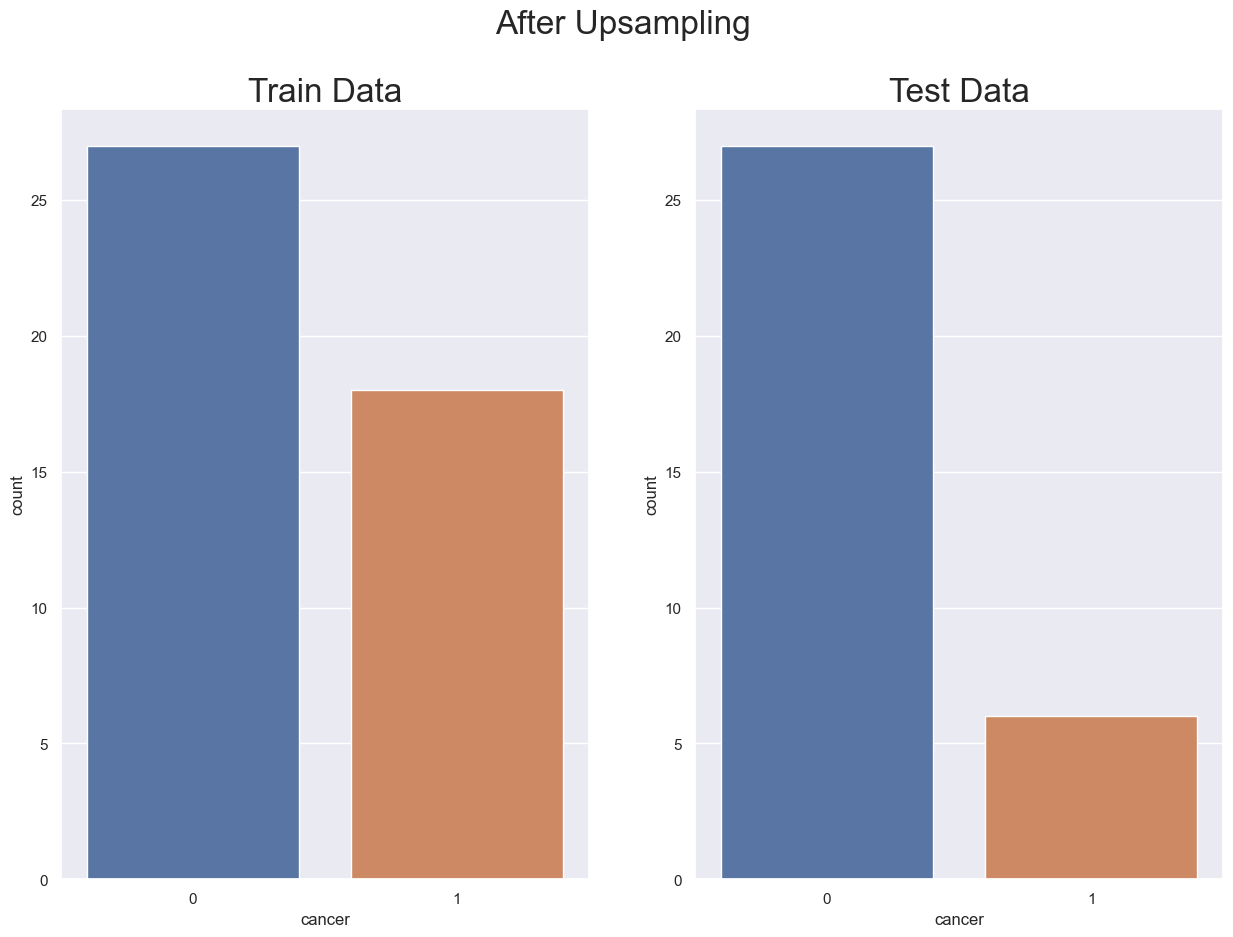

In [20]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x='cancer', data = train_data_upsampled, ax=axs[0])
axs[0].set_title('Train Data', fontsize = 24)
sns.countplot(x = 'cancer', data = test_data, ax=axs[1])
axs[1].set_title('Test Data', fontsize = 24)
fig.suptitle('After Upsampling', fontsize = 24)
plt.show()

Scaling the data

In [21]:
X_train = train_data_upsampled.drop(columns=['patient', 'cancer'])
y_train = train_data_upsampled['cancer']

X_test = test_data.drop(columns=['patient', 'cancer'])
y_test = test_data['cancer']

In [22]:
# Features scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Dimensionality Reduction and Clusterisation

In [23]:
reduced_train = PCA().fit_transform(X_train_scaled)
kmeans = KMeans(n_clusters=2, n_init=20)
kmeans.fit(train_data_upsampled)

KMeans(n_clusters=2, n_init=20)

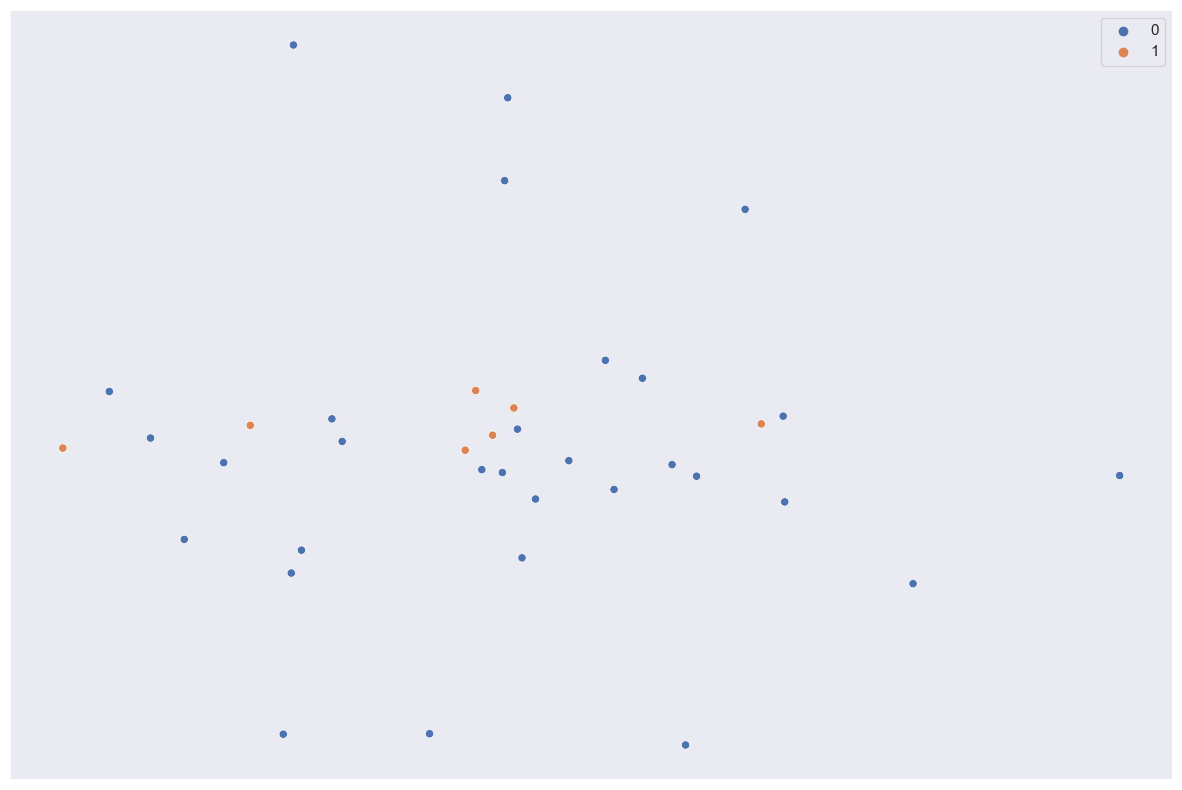

In [24]:
sns.scatterplot(x=reduced_train[0], y=reduced_train[1], hue=kmeans.labels_)
plt.xticks(())
plt.yticks(())
plt.show()

We can't define two clear clusters

26 features explain around 90% of the variance. From 7129 features to 26


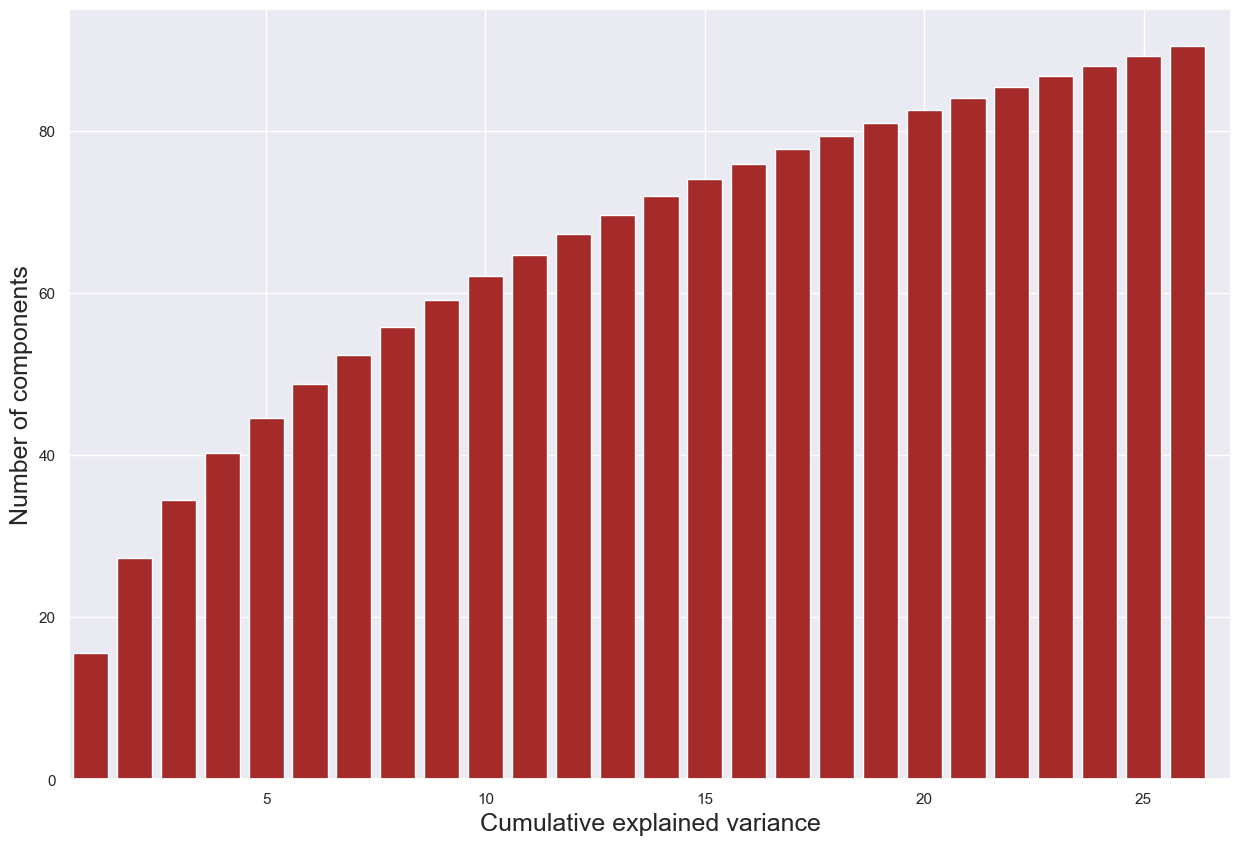

In [25]:
pca = PCA()
pca.fit_transform(X_train_scaled)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/ total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
print(k, ' features explain around 90% of the variance. From 7129 features to ',k, sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(1, k + 1), var_exp, color = 'brown')
plt.xlabel('Cumulative explained variance', fontsize = 18)
plt.ylabel('Number of components', fontsize = 18)
plt.xlim((0.5, k + 1))
plt.show()

We can approximately take 26 PC for downstream analysis

**Hierarchy**

- Let's see if hierarchial clusterisation give us 2 clusters based on cancer type

In [26]:
cancer_labels = train_data_upsampled['cancer'].map({0: le.classes_[0], 1: le.classes_[1]}).values
patient_labels = np.array(list(map(str, train_data_upsampled['patient'].values))).astype('object')+ '_' + cancer_labels

In [27]:
link = linkage(X_train_scaled, 'ward', 'euclidean')

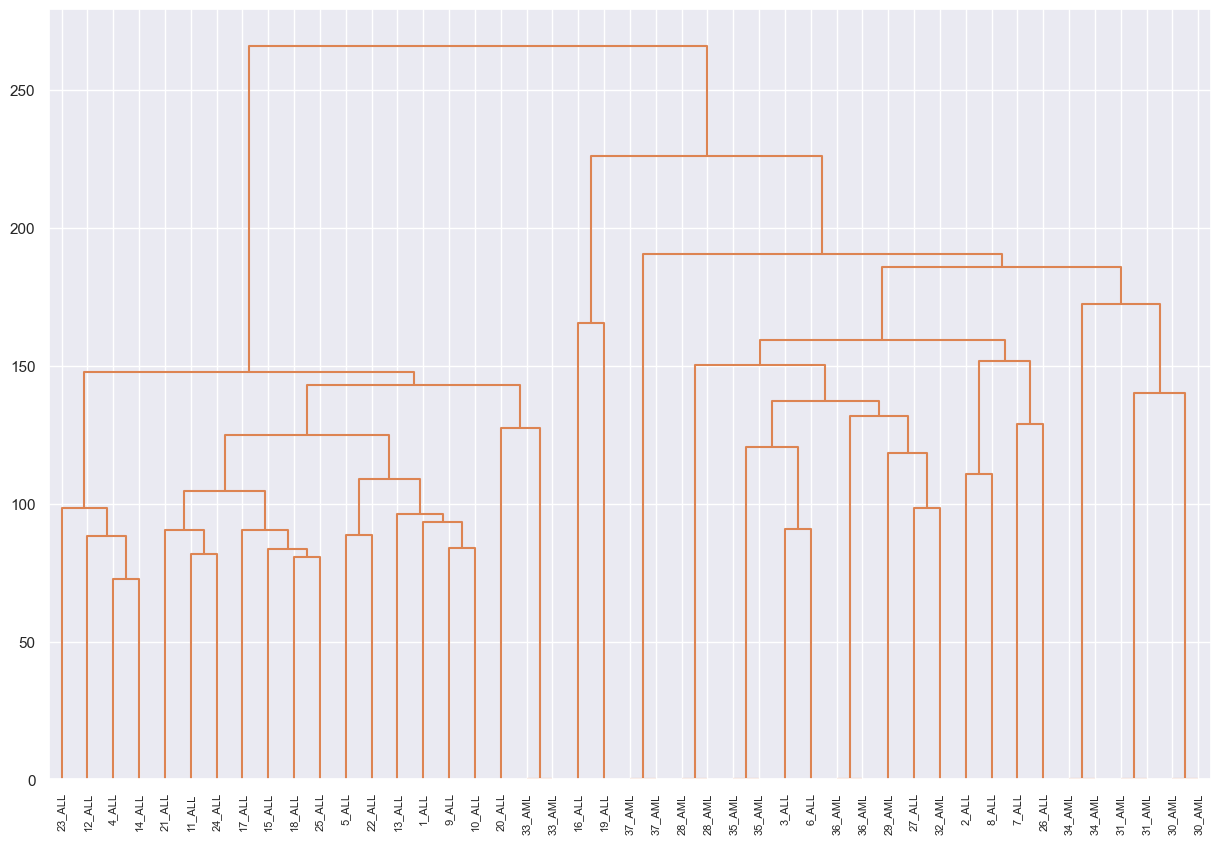

In [28]:
dm = dendrogram(link, color_threshold = 1250, labels = patient_labels)

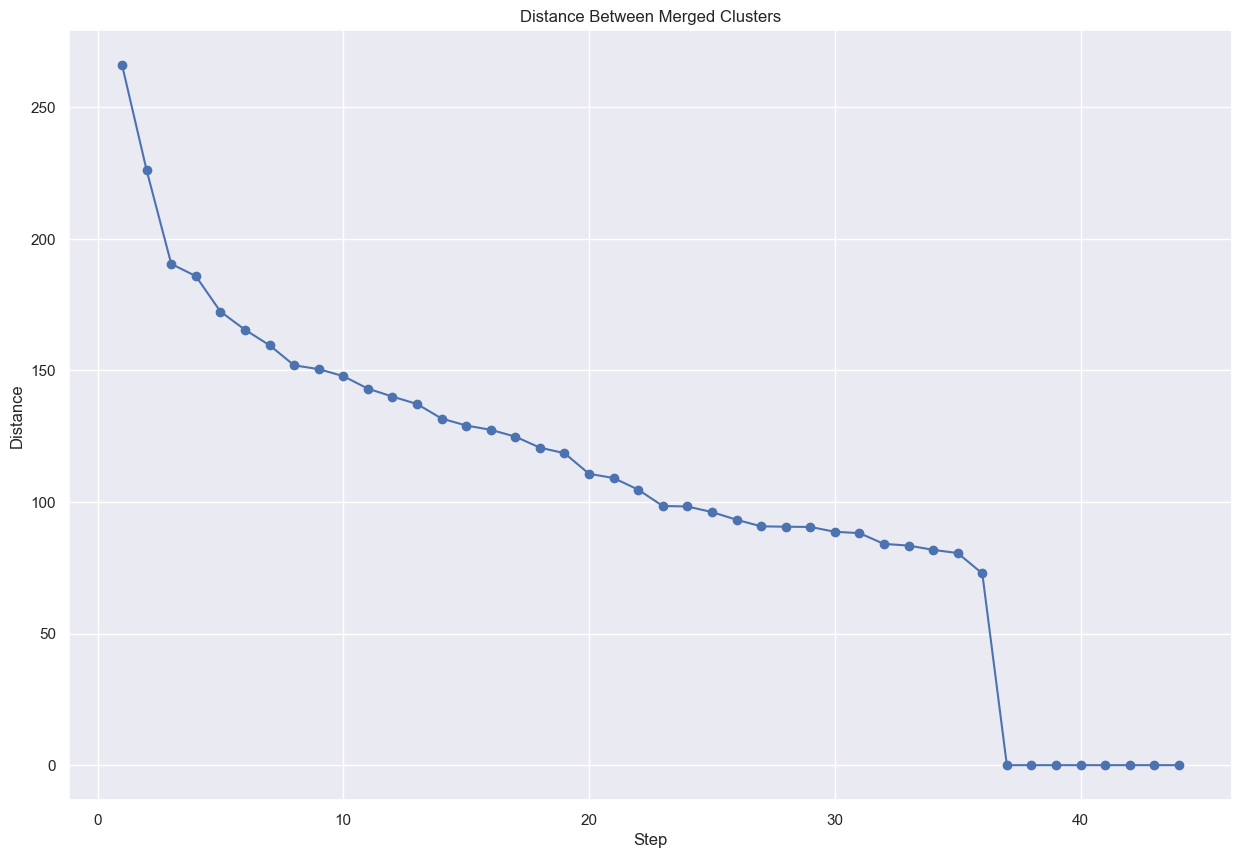

In [29]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker = 'o')
plt.title('Distance Between Merged Clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.show()

We can not take right part of this plot into account (because it is just an upsampled data). Dendrogram shows us that we can't extract two clusters based on cancer type, but the first large cluster contain almost only **ALL** and the second one contains both cancer types. Distance plot tells that it is a good way to distinguish 6 clusters. But it is just a preliminary analysis. Our main goal is to build a classifier

Naive Bayes accuracy: 0.697
True Positive Rate (Recall) for AML class: 0.833
True Negative Rate (Specificity) for ALL class: 0.667


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

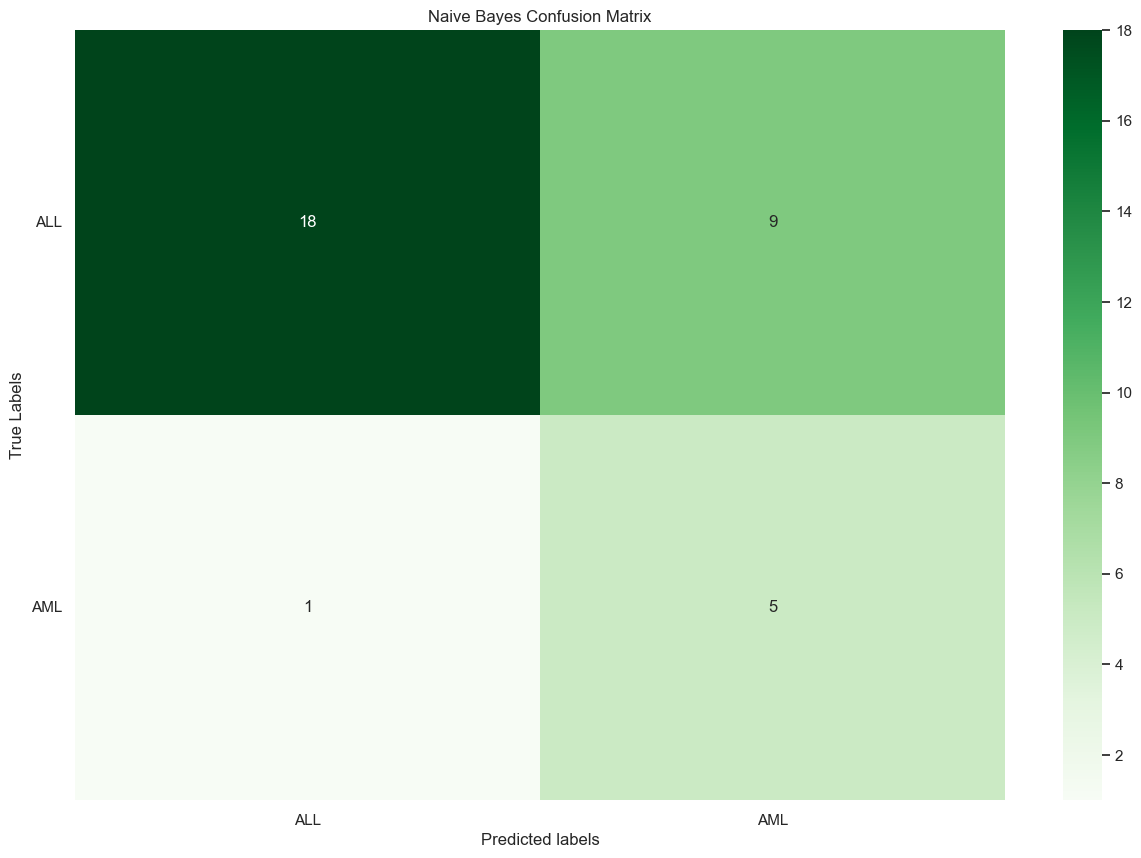

In [30]:
# Create a Gaussian classifier
nb_model = GaussianNB()

# Fit the Naive Bayes model on the training data
nb_model.fit(X_train_scaled, y_train)

# Predict labels for the testing data
nb_pred = nb_model.predict(X_test_scaled)

# Evaluate the accuracy of the Naive Bayes classification
print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))

# Compute confusion matrix
cm_nb = confusion_matrix(y_test,nb_pred)

# Extract true positives (TP), false positive (FP), true negatives (TN). and false negatives (FN) 
# from confusion matrix

TN, FP, FN, TP = cm_nb.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP/ (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN/ (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True Labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(['ALL','AML'])
ax.yaxis.set_ticklabels(['ALL','AML'], rotation=360)

Best Parameters:
 {'C': 0.001, 'penalty': 'l2'}
Logistic Regression accuracy: 0.758
True Positive Rate (Recall) for AML class: 0.833
True Negative Rate (Specificity) for ALL class: 0.741


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

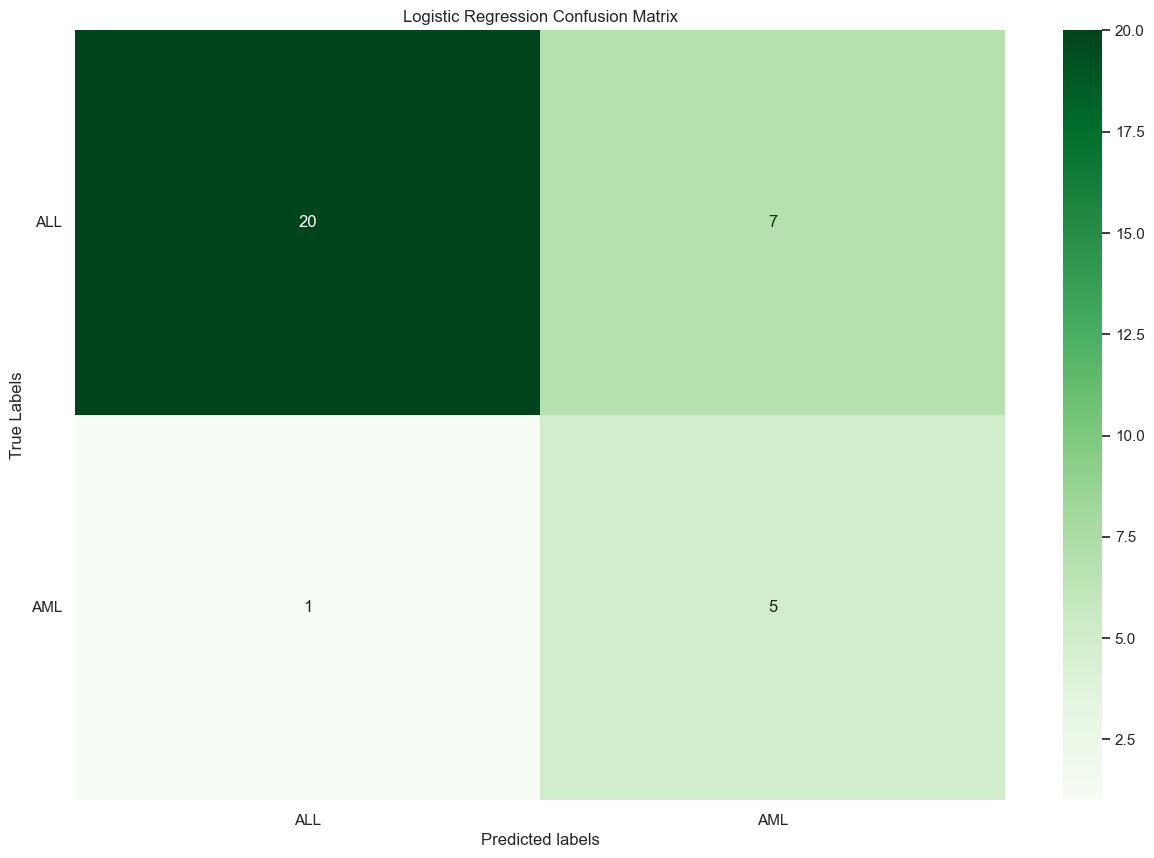

In [31]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the grid of hyperparameters
log_grid = {'C':[1e-03, 1e-2, 1e-1, 1, 10],
           'penalty':['l1', 'l2']}

# Create a logistic regression estimator
log_estimator = LogisticRegression(solver='liblinear')

# Create a grid search object
log_model = GridSearchCV(estimator=log_estimator,
                        param_grid=log_grid,
                        cv=3,
                        scoring='accuracy')

# Fit the grid search to find the best parameters
log_model.fit(X_train_scaled, y_train)

# Print the best parameters found by the grid search
print('Best Parameters:\n', log_model.best_params_)

# Select the best logistic regression model
best_log = log_model.best_estimator_

# Make predictions using the optimized model
log_pred = best_log.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, log_pred)
print('Logistic Regression accuracy:', round(accuracy,3))

# Compute confusion matrix
cm_log = confusion_matrix(y_test, log_pred)

# Extract true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) 
# from confusion matrix
TN, FP, FN, TP = cm_log.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP/ (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN/ (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

#Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True Labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(['ALL','AML'])
ax.yaxis.set_ticklabels(['ALL','AML'], rotation=360)

Best parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.727
True Positive Rate (Recall) for AML class: 0.333
True Negative Rate (Specificity) for ALL class: 0.815


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

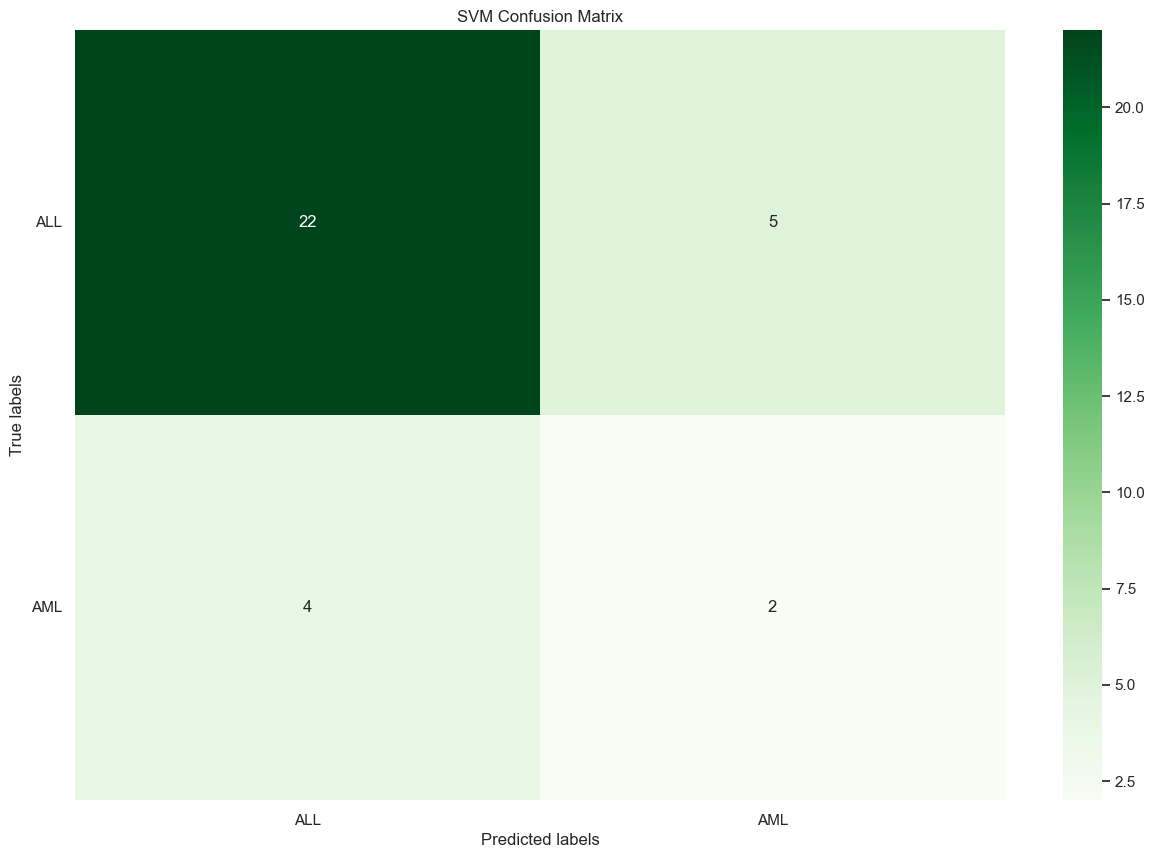

In [32]:
# Set random seed for reproducibility
random.seed(40)
np.random.seed(40)

# Parameter grid
svm_param_grid = {
    'C':[0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.001, 0.00001, 10],
    'kernel':['linear','rbf','poly'],
    'decision_function_shape': ['ovo', 'ovr']
}

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_scaled, y_train)

# Print the best parameters found by the grid search
print('Best parameters:\n', svm_grid.best_params_)

# Select the best SVC model
best_svc = svm_grid.best_estimator_

# Make predictions using the optimized parameters
svm_pred = best_svc.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, svm_pred)
print('SVM accuracy:', round(accuracy,3))

# Compute confusion matrix
cm_svm = confusion_matrix(y_test, svm_pred)

# Extract true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) from confusion matrix
TN, FP, FN, TP = cm_svm.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP / (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN / (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax=ax, fmt='g', cmap='Greens') 

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(['ALL', 'AML']) 
ax.yaxis.set_ticklabels(['ALL', 'AML'], rotation=360)

## Results

- Naive Bayes Accuracy: 0.697
- Logistic Regression Accuracy: 0.758
- SVM Accuracy: 0.727